In [11]:
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import math
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,LeakyReLU,ZeroPadding2D
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [12]:
from moviepy.editor import *
import cv2
import numpy as np
import pandas as pd
import os 
import shutil
import math
from matplotlib import pyplot as plt
from pydub import AudioSegment
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import librosa
import librosa.display
import soundfile
from datetime import date
from datetime import datetime
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from pickle import load
import librosa.display


In [13]:
faceDetector = cv2.dnn.readNetFromCaffe(os.path.join('Program','Models','deploy.prototxt.txt'),os.path.join('Program','Models','res10_300x300_ssd_iter_140000.caffemodel'))
loaded_model_face = keras.models.load_model(os.path.join('Program','Models','faceModel629-self.h5'))

In [14]:
loaded_model_voice = keras.models.load_model(os.path.join('Program','Models','voiceModel-aug-mel823.h5'))
scaler = load(open(os.path.join('Program','Models','scaler.pkl'), 'rb'))

In [15]:
def extractFrames(path):
    video = cv2.VideoCapture(path)
    
    frameRate = video.get(5) #frame rate
    extractedFrames = []

    while(video.isOpened()):
        frameId = video.get(1) #current frame number
        ret, frame = video.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0): #every second save the first frame
            rgbImage = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            extractedFrames.append(rgbImage)
    video.release()

    return extractedFrames

def getCroppedFaceRegions(frames,faceDetector):
    cropped = []
    
    for frame in frames:
        # Detect faces
        h, w = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
        faceDetector.setInput(blob)
        faces = faceDetector.forward()

        try:
            for i in range(faces.shape[2]):
                confidence = faces[0, 0, i, 2]
                if confidence > 0.7:
                    box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
                    (x1, y1, x2, y2) = box.astype("int")
                    face_rgb = frame[y1:y2,x1:x2]
                    cropped.append(cv2.resize(face_rgb,(48,48)))

        except cv2.error as e:
            print('[Unknown error] Invalid face!')
        
    return cropped

def faceRecog(faces,model):
    result = []
    print('Angry       Happy      Neutral    Sad')
    for face in faces:
        img = face.astype('float32') / 255.0
        img = img.reshape(-1, 48, 48, 1)
        print(model.predict(img)[0])
        result.append(model.predict(img)[0])
    
    faceTotal = len(result)
    finalFaceResult = []
    
    #calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalFaceResult.append(sumEmotion/faceTotal)
    
    # Round up to 4 decimal places
    finalFaceResult = [np.round(num, 4) for num in finalFaceResult]
    print('---------------------------------------------')
    print('Final face results:',finalFaceResult)
    
    return finalFaceResult

In [16]:
def extractAudio(path):
    destinationFolder = 'Extracted audio'
    destAudio = os.path.join(destinationFolder,'audio.wav')
    
    # Create directory if no such directory
    if not os.path.exists(destinationFolder):
        os.makedirs(destinationFolder)
    
    # Extract audio from the video
    video = VideoFileClip(path)
    video.audio.write_audiofile(destAudio, logger=None)
    video.close()
    
    # Delete the video
#     os.remove(path)
    
    # Convert to mono channel
    sound = AudioSegment.from_wav(destAudio)
    sound = sound.set_channels(1)
    
    # Extract audio for every 3 seconds
    length = int(sound.duration_seconds)    
    num = int(length/3)
    audioList = []
    
    for i in range(num):
        dest = os.path.join(destinationFolder,str(i+1)+'.wav')
        crop_file = sound[(i*3)*1000:]
        crop_file.export(dest, format='wav')
        
        # Read in again with desired format and library
        X, sample_rate = librosa.load(dest, duration=3, res_type='kaiser_fast',sr=44100,offset=0.5)
        audioList.append(X)

    # Delete the directory and the audio inside it
    if os.path.exists(destinationFolder):
        shutil.rmtree(destinationFolder)
    
    return audioList,sample_rate

def getMelSpect(audioList, sample_rate):
    dfAudio = pd.DataFrame()
    
    for X in audioList:
        df = pd.DataFrame(columns=['mel_spectrogram'])
        
        #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
        spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
        db_spec = librosa.power_to_db(spectrogram)
        
#         spect = librosa.feature.melspectrogram(y=y, sr=sr)
#         mel_spect = librosa.power_to_db(spect, ref=np.max)
#         print(len(db_spec))
        plt.rcParams["figure.figsize"] = (8,6)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])

        plt.show()
        
        #temporally average spectrogram
        log_spectrogram = np.mean(db_spec, axis = 0)
        df.loc[0] = [log_spectrogram]

        df = pd.DataFrame(df['mel_spectrogram'].values.tolist())
        dfAudio = pd.concat([dfAudio,df])
        
    return dfAudio

def voiceRecog(dfAudio,model,scaler):
    print('')
    # NORMALIZE DATA
    df = pd.DataFrame(scaler.transform(dfAudio))
    df = np.array(df)
    df = df.reshape(-1,259,1)
    result = model.predict(df).tolist()
    print('Angry   Happy   Neutral   Sad')
#     print(result)
#     result = model.predict(df)[0]
    for res in result:
        temp = [np.round(num, 4) for num in res]
        print(temp)
#         img = face.astype('float32') / 255.0
#         img = img.reshape(-1, 48, 48, 1)
#         print(model.predict(img)[0])
#         result.append(model.predict(img)[0])
    
    voiceTotal = len(result)
    finalVoiceResult = []
    
#     calculate for each emotion (since the fps of each video might be different)
    for i in range(4): 
        sumEmotion = 0
        for res in result:
            sumEmotion += res[i]
        finalVoiceResult.append(sumEmotion/voiceTotal)
    
    # Round up to 4 decimal places
    finalVoiceResult = [np.round(num, 4) for num in finalVoiceResult]
    print('---------------------------------------------')
    print('Final voice results:',finalVoiceResult)

    return finalVoiceResult

In [20]:
def display(faceResult,voiceResult):
    # Recreating dataframe without datetime and separated by recognition type
    emotions = ['Angry','Happy','Neutral','Sad']
    dfFace = pd.DataFrame(columns=['Emotion','Emotion Recognition Percentage'])
    c = 0
    
    for i,emo in enumerate(emotions):
        dfFace.loc[c] = [emo,(faceResult[i]+voiceResult[i])/2]
        c+=1

    # Setting of graphs
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set(font_scale = 1.5)
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Emotion Recognition (Fusion Result)")
    
    face = sns.barplot(x="Emotion",
                       y="Emotion Recognition Percentage",
                       data=dfFace,
                       ax=axes[0])
    
    face.set_title("Emotion Recognition (Fusion Result)")
    face.set_xlabel("Emotion")
    face.set_ylabel("Fusion Recognition Result")
    
    for p in face.patches:
        face.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

In [18]:
def shows(images):
    n = len(images)
    fig = plt.subplots(nrows=1, ncols=n)
    
    for i in range(n):
        num = 100 + n*10 + (i+1)
        plt.subplot(num)
        plt.title("")
        plt.xticks([]), plt.yticks([])
        if images[i].ndim == 2:
            plt.imshow(images[i], cmap='gray') #if not specified, it will treat this image as heat map
        else:
            plt.imshow(images[i])
        
    plt.show()
    
def shows2(images):
    num = 5
    n = math.ceil(len(images)/num)
    plt.figure(0)
    counter = 0
    stop = False

    for i in range(n):
        for j in range(num):
            plt.subplot2grid((n,num), (i,j))
#             plt.rcParams["figure.figsize"] = (1,1)
            plt.title("")
            plt.xticks([]), plt.yticks([])
            if images[counter].ndim == 2:
                plt.imshow(images[counter], cmap='gray') #if not specified, it will treat this image as heat map
            else:
                plt.imshow(images[counter])
            if counter == len(images)-1:
                stop = True
                break
            else:
                counter += 1
        if stop:
            break
        
    plt.show()

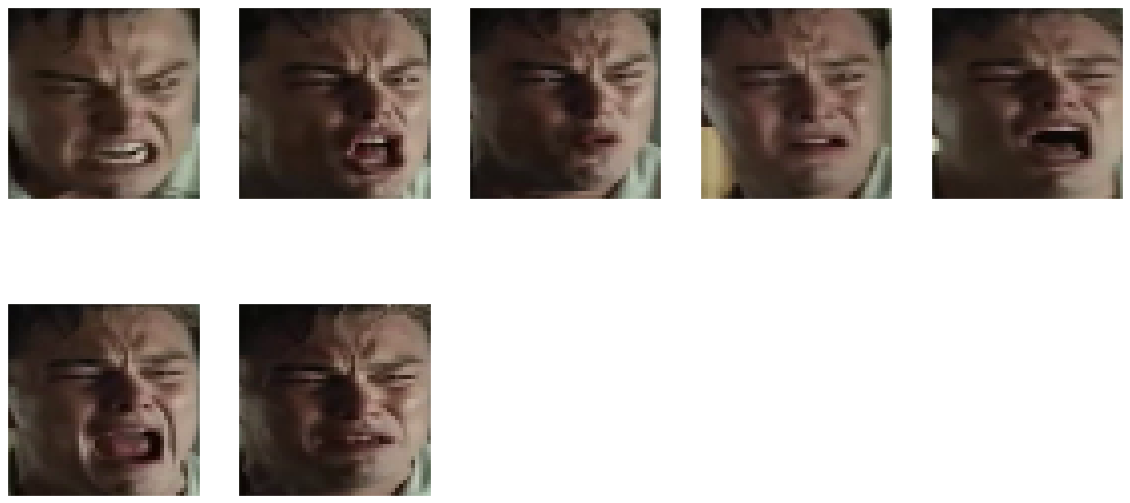

Angry       Happy      Neutral    Sad
[0.01799056 0.10360867 0.86416966 0.01423104]
[0.02542514 0.03785459 0.9177014  0.01901882]
[0.02391828 0.07686346 0.8838657  0.01535255]
[0.03465741 0.09781088 0.83296084 0.03457087]
[0.02360221 0.10914737 0.8501766  0.01707388]
[0.02955402 0.08872673 0.8633405  0.01837885]
[0.02341017 0.06032423 0.90026873 0.01599689]
---------------------------------------------
Final face results: [0.0255, 0.082, 0.8732, 0.0192]


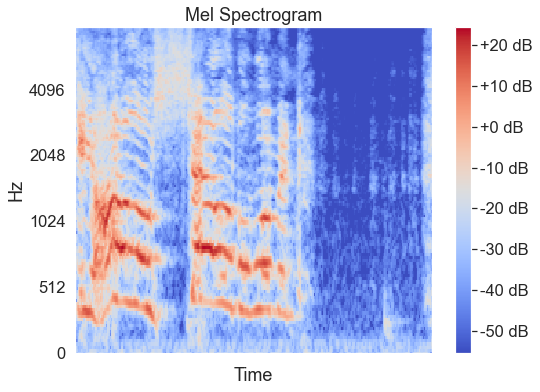

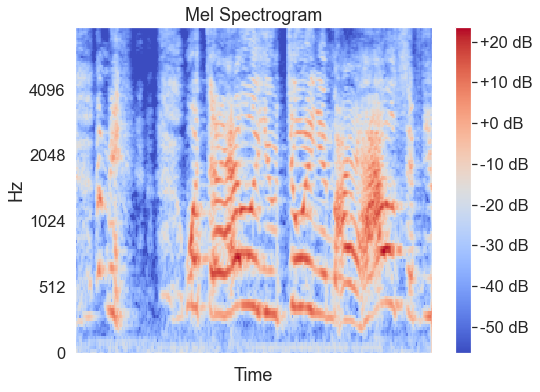


Angry   Happy   Neutral   Sad
[0.3602, 0.0201, 0.0006, 0.6191]
[0.0659, 0.0321, 0.0001, 0.9019]
---------------------------------------------
Final voice results: [0.2131, 0.0261, 0.0003, 0.7605]


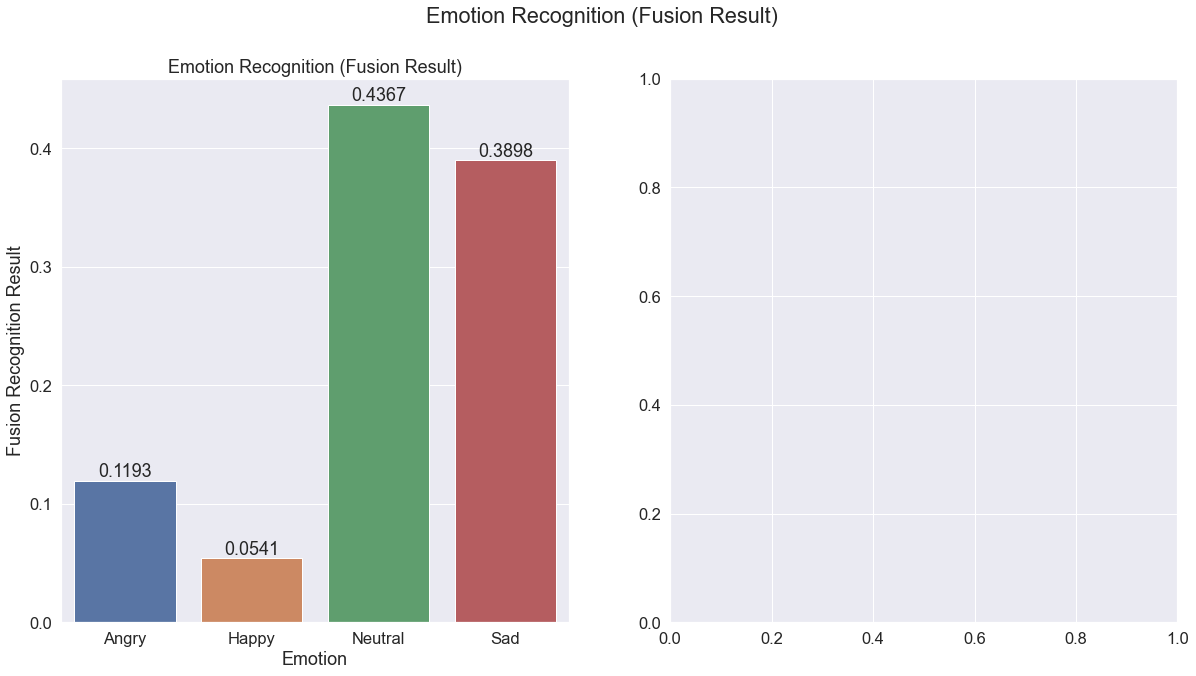

In [21]:
location = 'Sad4.mp4'
frames = extractFrames(location)
faces = getCroppedFaceRegions(frames,faceDetector)
shows2(faces)
finalFaceResult = faceRecog(faces,loaded_model_face)
# display(finalFaceResult)

audioList,sample_rate = extractAudio(location)
dfAudio = getMelSpect(audioList,sample_rate)
finalVoiceResult = voiceRecog(dfAudio,loaded_model_voice,scaler)
display(finalFaceResult,finalVoiceResult)